# Import libraries/modules

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import config
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
from IPython.display import IFrame
import pprint
from sklearn.preprocessing import StandardScaler

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn import cluster

import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn import cluster, datasets

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Top 100

In [4]:
response = requests.get('https://www.billboard.com/charts/hot-100/')
soup = BeautifulSoup(response.content)

# Scraping song titles
song_titles = []
for st in soup.select("ul li h3.c-title.a-no-trucate.a-font-primary-bold-s"):
    song_titles.append(st.get_text().strip())

# Scraping artist names
artists = []
for st in soup.select("ul li span.c-label.a-no-trucate.a-font-primary-s"):
    artists.append(st.get_text().strip())

# Creating the DataFrame
top_100 = pd.DataFrame({
    'Song': song_titles,
    'Artist': artists
})

In [6]:
top_100

,Song,Artist
0,Luther,Kendrick Lamar & SZA
1,Die With A Smile,Lady Gaga & Bruno Mars
2,Not Like Us,Kendrick Lamar
3,TV Off,Kendrick Lamar Featuring Lefty Gunplay
4,A Bar Song (Tipsy),Shaboozey
...,...,...
95,Born Again,LISA Featuring Doja Cat & RAYE
96,Twenties,Giveon
97,Deeper,PARTYNEXTDOOR
98,Holy Smokes,Bailey Zimmerman


# Machine Learning

## Create dataframe & normalize

In [10]:
df = pd.read_csv('Data-resources/audio_features_dataset.csv')

In [12]:
df.drop(columns=['Unnamed: 0', 'album_name', 'popularity', 'duration_ms'], inplace = True)

In [14]:
df.shape

(114000, 16)

In [16]:
df.drop_duplicates(inplace = True)

In [18]:
df.shape

(89741, 16)

In [20]:
df.dropna(how = 'any', inplace = True)

In [22]:
df.shape

(89740, 16)

In [24]:
features = ['danceability', 'loudness', 'valence', 'tempo', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'key', 'energy',]
info = df.drop(columns=features)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[features])

# Convert df_scaled back into a DataFrame with the correct column names
features_scaled = pd.DataFrame(features_scaled, columns=features, index=df.index)

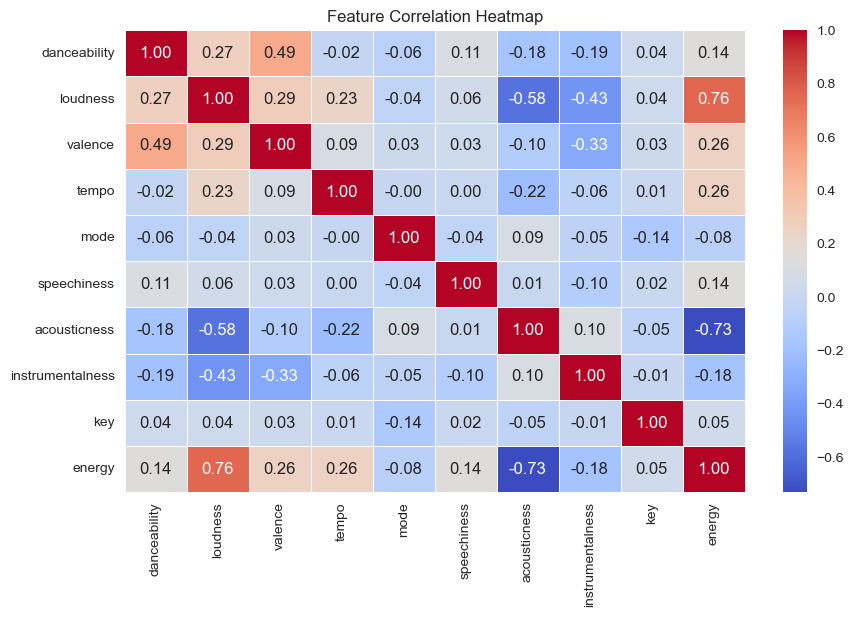

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute the correlation matrix
corr_matrix = features_scaled.corr()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title and labels
plt.title("Feature Correlation Heatmap")
plt.show()

In [41]:
features_scaled.drop(columns=['loudness'], inplace = True)

## kmeans 

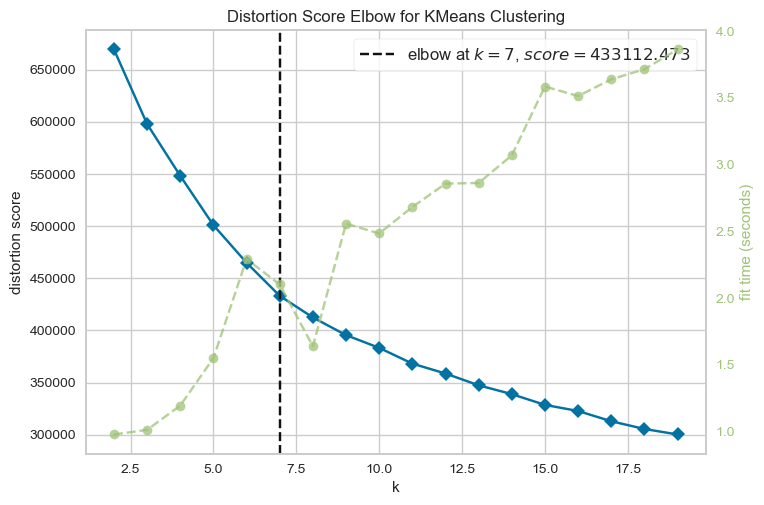

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:
model = cluster.KMeans(init='k-means++', n_init=10, random_state=42)
visualizer = KElbowVisualizer(model, k=(2,20))
visualizer.fit(features_scaled)
visualizer.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

kmeans = KMeans(n_clusters=8, init='k-means++', n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, cluster_labels, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features_scaled.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='magma')
plt.title('Feature Importance (Random Forest on Cluster Labels)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Print importance scores
print(importance_df)

## Silhouette Score

In [65]:
from sklearn.metrics import silhouette_score
import pickle
import os
from sklearn.cluster import KMeans

# Define folder name
pickle_folder = "pickles"

# Create the folder if it doesn't exist
os.makedirs(pickle_folder, exist_ok=True)

cluster_range = range(5, 20)
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)

    # Save model inside "pickles" folder
    filename = os.path.join(pickle_folder, f"kmeans_{n_clusters}.pickle")

    with open(filename, "wb") as f:
        pickle.dump(kmeans, f)

    # Compute silhouette score
    score = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores.append(score)

KeyboardInterrupt: 

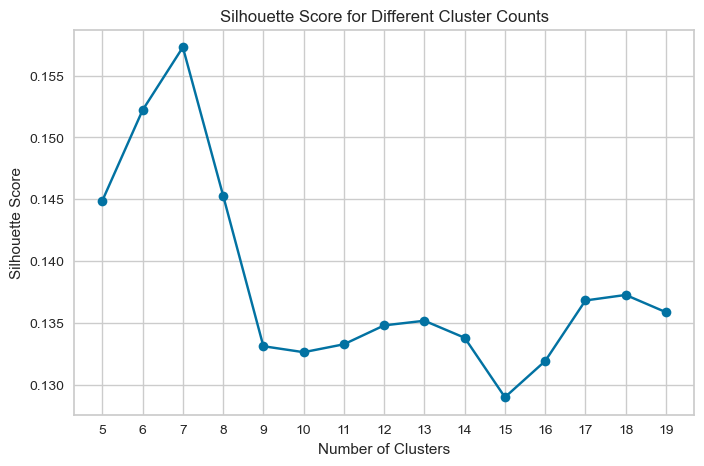

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Cluster Counts")
plt.xticks(cluster_range)
plt.grid(True)  # Dashed grid with better visibility
plt.show()

In [42]:
def load(filename = "file.pickle"):
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)

    except FileNotFoundError:
        print("File Not Foundation !")

In [62]:
kmeans6 = load("pickles/kmeans_6.pickle")

In [64]:
features_scaled['genre'] = kmeans6.predict(features_scaled)

In [92]:
features_scaled['genre'].value_counts()

genre
1    30884
2    21211
3    18289
0    10569
5     6744
4     2043
Name: count, dtype: int64

In [68]:
# Combine scaled features with the original non-feature columns
df_final = pd.concat([info, features_scaled], axis=1)

In [94]:
df_final['genre'] = df_final['genre'].replace({0: 'sample 1',
                                               1: 'sample 2',
                                               2: 'sample 3',
                                               3: 'sample 4',
                                               4: 'sample 5',
                                               5: 'sample 6'})

In [96]:
df_final

,track_id,artists,track_name,explicit,liveness,danceability,loudness,valence,tempo,mode,speechiness,acousticness,instrumentalness,key,energy,cluster,genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,False,0.3580,0.644253,0.335727,0.934047,-1.133599,-1.324621,0.490458,-0.875166,-0.535482,-1.203275,-0.675975,2,sample 3
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost - Acoustic,False,0.1010,-0.804604,-1.673087,-0.770269,-1.479843,0.754933,-0.098364,1.760810,-0.535468,-1.203275,-1.825602,3,sample 4
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,False,0.1170,-0.702731,-0.236524,-1.329497,-1.518259,0.754933,-0.280219,-0.349626,-0.535485,-1.484183,-1.073473,3,sample 4
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Can't Help Falling In Love,False,0.1320,-1.676182,-1.918228,-1.241999,1.981635,0.754933,-0.451480,1.704650,-0.535266,-1.484183,-2.240247,3,sample 4
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,False,0.0829,0.315996,-0.226373,-1.150696,-0.070030,0.754933,-0.307585,0.415925,-0.535485,-0.922368,-0.746122,3,sample 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,Sleep My Little Boy,False,0.0863,-2.208184,-1.511831,-1.657046,0.130717,0.754933,-0.399395,0.921365,2.330062,-0.079646,-1.556706,5,sample 6
113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,Water Into Light,False,0.1050,-2.196865,-1.880499,-1.652861,-1.222517,-1.324621,-0.417934,1.967716,2.478280,-1.484183,-2.016557,5,sample 6
113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Miss Perfumado,False,0.0839,0.378251,-0.458874,1.040567,0.342654,-1.324621,-0.401161,1.592330,-0.535485,-1.484183,-1.190384,3,sample 4
113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Friends,False,0.2700,0.140548,-0.457725,-0.214844,0.461588,0.754933,-0.509744,0.155815,-0.535485,0.482169,-0.500608,3,sample 4


## Evaluation

In [60]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# Compute the Calinski-Harabasz Index
ch_score = calinski_harabasz_score(features_scaled, cluster_labels)
print(f"Calinski-Harabasz Index: {ch_score}")

# Compute the Davies-Bouldin Index
db_score = davies_bouldin_score(features_scaled, cluster_labels)
print(f"Davies-Bouldin Index: {db_score}")

Calinski-Harabasz Index: 8104.784686131926
Davies-Bouldin Index: 1.639764608784711


# Building Program

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from IPython.display import IFrame
import random
from fuzzywuzzy import process  

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=config.client_id,
                                                               client_secret=config.client_secret))

def perform_trending_action():
    print("Here's a song from 'trending'") 

    # Select a random row from the top_100 DataFrame
    random_row = top_100.sample()

    # Access the Song and Artist from the random row
    random_search_song = random_row['Song'].values[0]  # Extracts the 'Song' value
    random_search_artist = random_row['Artist'].values[0]  # Extracts the 'Artist' value

    # Combine song and artist for the search query
    random_search = f"{random_search_song} - {random_search_artist}"

    # Perform the search query on Spotify
    results = sp.search(q=random_search, limit=1)

    # Extract the track ID from the search results
    random_search_id = results["tracks"]["items"][0]["id"]

    # Create and return the IFrame to embed the track in the output
    return IFrame(src=f"https://open.spotify.com/embed/track/{random_search_id}",
                  width="320",
                  height="80",
                  frameborder="0",
                  allowtransparency="true",
                  allow="encrypted-media")

def perform_genre_action(genre, df_final):
    print(f"Here's a song from {genre}")

    # Filter the dataframe based on the genre using an f-string
    filtered_df = df_final[df_final['genre'] == f"{genre}"]
    
    if not filtered_df.empty:
        # Randomly select a song from the filtered dataframe
        random_song = filtered_df.sample(n=1)

        # Get the track_id of the selected song
        track_id = random_song['track_id'].values[0]
        
        # Return the IFrame with the selected song's track ID
        return IFrame(src=f"https://open.spotify.com/embed/track/{track_id}",
                      width="320",
                      height="80",
                      frameborder="0",
                      allowtransparency="true",
                      allow="encrypted-media")
    else:
        print(f"No songs found for the genre {genre}.")
        return None

# List of available genres
genres = ['trending', 'sample 1', 'sample 2', 'sample 3', 'sample 4', 'sample 5', 'sample 6']

# Function to check user input with fuzzy matching
def check_input(input_string):
    # Get the closest match from the genres list with a threshold of 80%
    match, score = process.extractOne(input_string.lower(), genres)
    
    if score >= 80:  
        if match == 'trending':
            display(perform_trending_action())  
        elif match in genres:
            display(perform_genre_action(match, df_final))
    else:
        print(f"'{input_string}' didn't match any results. Please try again.")

first_iteration = True  # Flag to check if it's the first iteration
while True:
    if first_iteration:
        user_input = input(f"Please choose a genre from these options:\n{genres}\n(or type 'exit' to quit) ")
        first_iteration = False  # Set to False after the first iteration
    else:
        user_input = input(f"Choose your next genre from the above options:\n(or type 'exit' to quit) ")
    
    if user_input.lower() == 'exit':
        print("Goodbye!")
        break  # Exit the loop if user types 'exit'
    
    check_input(user_input)

Please choose a genre from these options:
['trending', 'sample 1', 'sample 2', 'sample 3', 'sample 4', 'sample 5', 'sample 6']
(or type 'exit' to quit)  sample 1


Here's a song from sample 1


Choose your next genre from the above options:
(or type 'exit' to quit)  sample 1


Here's a song from sample 1


Choose your next genre from the above options:
(or type 'exit' to quit)  sample 1


Here's a song from sample 1


Choose your next genre from the above options:
(or type 'exit' to quit)  sample 1


Here's a song from sample 1


Choose your next genre from the above options:
(or type 'exit' to quit)  sample 1


Here's a song from sample 1


Choose your next genre from the above options:
(or type 'exit' to quit)  sample 1


Here's a song from sample 1


In [ ]:
df_final['genre'] = df_final['genre'].replace({'sample 1': '',
                                               'sample 2': '',
                                               'sample 3': '',
                                               'sample 4': '',
                                               'sample 5': '',
                                               'sample 6': ''})